In [28]:
# src/train_pytorch.py (Modified for Session Classification)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split # Random split is OK here
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# import sys
# import os
# from pathlib import Path

# current_dir = Path(os.getcwd())
# sys.path.append(str(current_dir.parent))

from pytorch_utils import TimeSeriesDataset, LSTMModel # Our custom classes

### Clasification

In [2]:
# --- Step 1: Load CORRECT Data ---
print("Step 1: Loading session sequence data...")
X = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_sequences_X_padded.npy')
y = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_targets_y_class.npy') # Load the classification target
y_reg = np.load('../data/processed/hyp_a_xauusd_h1_2018_session_targets_y_reg.npy') # Load the reg target


# --- Step 2: Create Datasets and DataLoaders ---
# For session-to-session prediction, a random split is acceptable.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_dataset_reg = TimeSeriesDataset(X_train, y_train_reg)
test_dataset_reg = TimeSeriesDataset(X_test, y_test_reg)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader_reg = DataLoader(train_dataset_reg, batch_size=64, shuffle=True)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=64, shuffle=False)
print("DataLoaders created.")

Step 1: Loading session sequence data...
DataLoaders created.


In [13]:
X[1],y[1]

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-1.08187971, -1.07766116, -1.07921718, -1.07819699,  0.3234584 ],
        [-1.07824367, -1.07938434, -1.08074401, -1.08199787, -0.51209084],
        [-1.08211844, -1.08327066, -1.08352175, -1.08521117, -0.31578005],
        [-1.08529538, -1.08772527, -1.0874768 , -1.08871825,  0.22308018],
        [-1.08876614, -1.09010839, -1.09240682, -1.09251912,  0.64190772],
        [-1.09256745, -1.09355475, -1.09093517, -1.092868  , -0.00411621],
        [-1.09291636, -1.09474631, -1.09187334, -1.09244568, -0.44493804],
        [-1.09249399, -1.0926565 , -1.08988662, -1.09101346, -0.47441976],
        [-1.09106162, -1.08939345, -1.08916919, -1.08717587, -0.11736343]]),
 np.int64(1))

In [14]:
X.shape

(1995, 10, 5)

In [10]:
# --- Step 3: Initialize Model, Loss, and Optimizer for CLASSIFICATION ---
input_size = X.shape[2]    # Num features per hour (5)
hidden_size = 50
output_size = 1 # We still output one number, but it will be a logit for classification

model = LSTMModel(input_size, hidden_size, output_size)
# USE THE CORRECT LOSS FOR BINARY CLASSIFICATION!
criterion = nn.BCEWithLogitsLoss() # This is the standard for binary classification
criterion_reg = nn.L1Loss() # This is the standard for reg
# criterion_reg = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("Model, Loss, and Optimizer initialized for Classification.")

Model, Loss, and Optimizer initialized for Classification.


In [43]:
# --- Step 4: The Training Loop ---
print("\nStep 4: Starting training loop...")
num_epochs = 100
model_class = model
for epoch in range(num_epochs):
    model_class.train()
    for batch_X, batch_y in train_loader:
        outputs = model_class(batch_X).squeeze() # Get model output
        loss = criterion(outputs, batch_y.float()) # Compare with target

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")


Step 4: Starting training loop...
Epoch [1/100], Loss: 0.1184
Epoch [2/100], Loss: 0.1642
Epoch [3/100], Loss: 0.0817
Epoch [4/100], Loss: 0.1337
Epoch [5/100], Loss: 0.0885
Epoch [6/100], Loss: 0.1064
Epoch [7/100], Loss: 0.1039
Epoch [8/100], Loss: 0.1045
Epoch [9/100], Loss: 0.0887
Epoch [10/100], Loss: 0.1695
Epoch [11/100], Loss: 0.1531
Epoch [12/100], Loss: 0.1194
Epoch [13/100], Loss: 0.1027
Epoch [14/100], Loss: 0.2344
Epoch [15/100], Loss: 0.2877
Epoch [16/100], Loss: 0.2636
Epoch [17/100], Loss: 0.1757
Epoch [18/100], Loss: 0.1435
Epoch [19/100], Loss: 0.1817
Epoch [20/100], Loss: 0.3674
Epoch [21/100], Loss: 0.2095
Epoch [22/100], Loss: 0.3617
Epoch [23/100], Loss: 0.1392
Epoch [24/100], Loss: 0.1575
Epoch [25/100], Loss: 0.0601
Epoch [26/100], Loss: 0.1518
Epoch [27/100], Loss: 0.1033
Epoch [28/100], Loss: 0.1750
Epoch [29/100], Loss: 0.1448
Epoch [30/100], Loss: 0.1248
Epoch [31/100], Loss: 0.1125
Epoch [32/100], Loss: 0.0951
Epoch [33/100], Loss: 0.1727
Epoch [34/100], L


--- Evaluating Model with Detailed Metrics ---

--- Classification Report ---
              precision    recall  f1-score   support

 Bearish (0)       0.51      0.45      0.48       201
 Bullish (1)       0.50      0.57      0.53       198

    accuracy                           0.51       399
   macro avg       0.51      0.51      0.51       399
weighted avg       0.51      0.51      0.51       399


--- Confusion Matrix ---


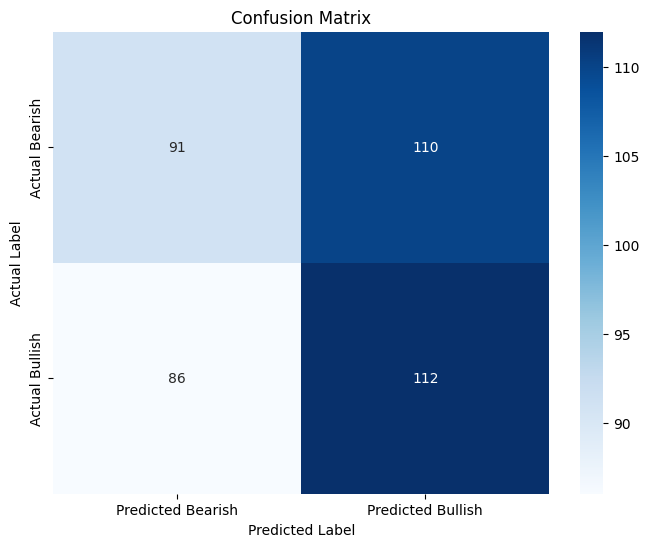

In [ ]:
# REPLACE your old "Step 5" in src/train_pytorch.py with this new section

# --- Step 5: Detailed Evaluation on Test Set ---
print("\n--- Evaluating Model with Detailed Metrics ---")
model_class.eval() # Set the model to evaluation mode (very important!)

# We need to collect all predictions and true labels from the test set
all_predictions = []
all_labels = []

# torch.inference_mode() tells PyTorch we are not training, so it doesn't need to calculate gradients.
# This makes evaluation much faster and uses less memory.
with torch.inference_mode():
    for batch_X, batch_y in test_loader:
        # 1. Get the raw model output (logits)
        outputs = model_class(batch_X).squeeze()
        
        # 2. Convert logits to final predictions (0 or 1)
        predicted = torch.round(torch.sigmoid(outputs))
        
        # 3. Move predictions and labels to the CPU and convert to NumPy arrays
        #    so that scikit-learn can use them.
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# --- 5a. Generate the Classification Report ---
print("\n--- Classification Report ---")
# This report gives you precision, recall, and f1-score for each class.
report = classification_report(all_labels, all_predictions, target_names=['Bearish (0)', 'Bullish (1)'])
print(report)

# --- 5b. Generate and Visualize the Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_predictions)

# Use seaborn to create a nice heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Bearish', 'Predicted Bullish'], 
            yticklabels=['Actual Bearish', 'Actual Bullish'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# --- Step 6: Save the Model --- (This part is unchanged)
model_path = '../models/hyp_a_xauusd_h1_2018_pytorch_lstm_classifier_51acc_50p_60r.pth'
torch.save(model_class.state_dict(), model_path)
print(f"\nClassification model saved to {model_path}")


Classification model saved to ../models/hyp_a_xauusd_h1_2018_pytorch_lstm_classifier_51acc_50p_60r.pth


### reg training

In [25]:
# --- Step 4: The Training Loop ---
print("\nStep 4: Starting training loop...")
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader_reg:
        outputs = model(batch_X).squeeze() # Get model output
        loss = criterion_reg(outputs, batch_y.float()) # Compare with target

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training finished.")


Step 4: Starting training loop...
Epoch [1/100], Loss: 0.0085
Epoch [2/100], Loss: 0.0055
Epoch [3/100], Loss: 0.0058
Epoch [4/100], Loss: 0.0068
Epoch [5/100], Loss: 0.0057
Epoch [6/100], Loss: 0.0063
Epoch [7/100], Loss: 0.0065
Epoch [8/100], Loss: 0.0048
Epoch [9/100], Loss: 0.0050
Epoch [10/100], Loss: 0.0058
Epoch [11/100], Loss: 0.0059
Epoch [12/100], Loss: 0.0057
Epoch [13/100], Loss: 0.0054
Epoch [14/100], Loss: 0.0070
Epoch [15/100], Loss: 0.0078
Epoch [16/100], Loss: 0.0053
Epoch [17/100], Loss: 0.0070
Epoch [18/100], Loss: 0.0076
Epoch [19/100], Loss: 0.0082
Epoch [20/100], Loss: 0.0065
Epoch [21/100], Loss: 0.0064
Epoch [22/100], Loss: 0.0068
Epoch [23/100], Loss: 0.0043
Epoch [24/100], Loss: 0.0046
Epoch [25/100], Loss: 0.0063
Epoch [26/100], Loss: 0.0077
Epoch [27/100], Loss: 0.0054
Epoch [28/100], Loss: 0.0090
Epoch [29/100], Loss: 0.0051
Epoch [30/100], Loss: 0.0066
Epoch [31/100], Loss: 0.0074
Epoch [32/100], Loss: 0.0043
Epoch [33/100], Loss: 0.0066
Epoch [34/100], L

In [ ]:
# --- Step 5: Evaluation for REGRESSION ---
model.eval()
total_mae = 0.0
with torch.inference_mode():
    for batch_X, batch_y in test_loader_reg:
        outputs = model(batch_X).squeeze()
        # CHANGE: We directly calculate the MAE. No sigmoid, no rounding.
        mae = criterion(outputs, batch_y.float())
        total_mae += mae.item() * batch_X.size(0)

avg_mae = total_mae / len(test_dataset)
print(f'\nMean Absolute Error (MAE) on test data: {avg_mae:.6f}')
print("This means our model's return prediction is off by this amount on average.")


Mean Absolute Error (MAE) on test data: 0.692496
This means our model's return prediction is off by this amount on average.


In [27]:
# --- Step 6: Save the Model ---
model_path = '../models/hyp_a_xauusd_h1_2018_pytorch_lstm_regressor_0692_mae.pth'
torch.save(model.state_dict(), model_path)
print(f"Regression model saved to {model_path}")

Regression model saved to ../models/hyp_a_xauusd_h1_2018_pytorch_lstm_regressor_0692_mae.pth
